In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import datetime
from time import time
import math


import seaborn as sns
sns.set(style='ticks')
sns.set_context("notebook", font_scale=1)
sns.set_style("darkgrid")


import warnings
warnings.filterwarnings('ignore')
import datetime
from datetime import date

%matplotlib inline

# Import supplementary visualization code visuals.py
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from random import *

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from tensorflow.python.framework import ops

#### Importing input files

In [2]:
### Import 2016 data for Training the model
ml_features = pd.read_csv("./features/medicine_finalized_features.csv")

In [3]:
## Function to convert labels to one hot array for Neural Network Output
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

#### Preparing features sets

In [4]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

features = ml_features.drop(['PatientGuid','acid_reflux_patient'],axis=1)
targets = ml_features['acid_reflux_patient'].values

# Feature normalization on the input
X = preprocessing.MinMaxScaler(feature_range=(-1,+1)).fit_transform(features)
# Encode the output using the one-hot encoding
y = convert_to_one_hot(targets, 2)
# Split in train/test sets

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y.T, test_size = 0.15, random_state = 0,stratify=targets)
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T


# Show the results of the split
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 4199
number of test examples = 741
X_train shape: (9203, 4199)
Y_train shape: (2, 4199)
X_test shape: (9203, 741)
Y_test shape: (2, 741)


## Build Neural Network Model

#### Defining PlaceHolder Variables for Neural Network

In [5]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    
    X = tf.placeholder(dtype=tf.float32,shape=[n_x, None])
    Y = tf.placeholder(dtype=tf.float32,shape=[n_y, None])

    
    return X, Y

#### Initializing Parameters

Intializing parameters for 3 layers network

In [6]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
   
    W1 = tf.get_variable("W1", [25,X_train.shape[0]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [2,1], initializer = tf.zeros_initializer())


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

#### Implemntation of Forward propogation

In [7]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                            # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                        # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                       # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                       # Z3 = np.dot(W3,Z2) + b3
    
    
    return Z3

#### Function to compute Cost

In [8]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
   
    
    return cost

#### Function to create minibatches

In [9]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

#### Function to Train the Model

In [10]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    
    X, Y = create_placeholders(n_x, n_y)
   

    # Initialize parameters
  
    parameters = initialize_parameters()

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
   
    Z3 = forward_propagation(X, parameters)

    
    # Cost function: Add cost function to tensorflow graph
    
    cost = compute_cost(Z3, Y)
   
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
   
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                
                _ , minibatch_cost, prediction = sess.run([optimizer, cost, Z3], feed_dict={X: minibatch_X, Y: minibatch_Y})
               
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        Z3 = sess.run(Z3, feed_dict={X: X_test, Y: Y_test})

        
        return parameters, Z3

Cost after epoch 0: 0.404110
Cost after epoch 100: 0.371613
Cost after epoch 200: 0.352141
Cost after epoch 300: 0.289137
Cost after epoch 400: 0.253955
Cost after epoch 500: 0.252384
Cost after epoch 600: 0.216146
Cost after epoch 700: 0.202727
Cost after epoch 800: 0.196040
Cost after epoch 900: 0.183911
Cost after epoch 1000: 0.174174
Cost after epoch 1100: 0.177009
Cost after epoch 1200: 0.146359
Cost after epoch 1300: 0.135556
Cost after epoch 1400: 0.137887


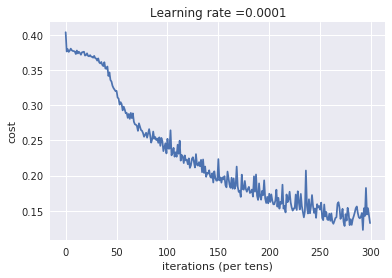

Parameters have been trained!
Train Accuracy: 0.9657061
Test Accuracy: 0.8704454


In [11]:
parameters, prediction = model(X_train, Y_train, X_test, Y_test)

#### Analysis of Predicted Data

In [12]:
prediction.shape

(2, 741)

In [13]:
result = np.argmax(prediction,axis=0)

In [14]:
actual = np.argmax(Y_test,axis=0)

In [15]:
print ("Test accuracy: " + str(accuracy_score(actual, result)))
tn, fp, fn, tp = confusion_matrix(actual, result).ravel()
Recall = round(tp*100/(tp+fn),2)
True_Negative_Rate = round(tn*100/(tn+fp),2)
Precision = round(tp*100/(tp+fp),2)
print("Precision: %s" % str(round(Precision,2)) + "%")
print("Recall: %s" % str(round(Recall,2)) + "%")
print("True_Negative_Rate: %s" % str(round(True_Negative_Rate,2)) + "%")

Test accuracy: 0.8704453441295547
Precision: 47.3%
Recall: 38.04%
True_Negative_Rate: 93.99%


## Presentation of the Results

In [16]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.coolwarm,
                          chart_type='Recall'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        if chart_type == 'Recall':
            cm = cm.astype('float')*100 / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized Recall basedconfusion matrix")
        else:
            cm = cm.astype('float')*100 /cm.sum(axis=0)[np.newaxis, :]
            print("Normalized Precision based confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    #print (cm.shape)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(format(cm[i, j], fmt))+"%" if normalize else format(cm[i, j], fmt),
                 horizontalalignment="center", family='sans-serif', size=16,weight='bold',
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Confusion matrix to show distribution of Predicted Data

Total_sample_size: 741


Confusion matrix, without normalization


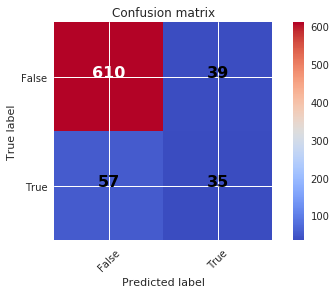

In [17]:
cnf_matrix = confusion_matrix(actual, result)
np.set_printoptions(precision=2)
plt.figure()
print ("Total_sample_size: " + str(actual.shape[0]))
print("\n")
plot_confusion_matrix(cnf_matrix, classes=["False", "True"],normalize=False,
                      title='Confusion matrix')

#### Confusion Matrix to show precision

Normalized Precision based confusion matrix


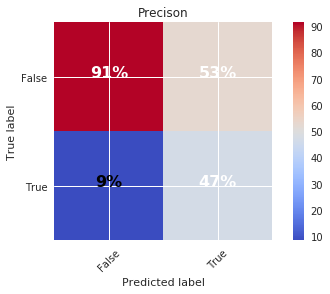

In [18]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["False", "True"],normalize=True,
                      title='Precison',chart_type='Precision' )

#### Confusion Matrix to show Recall

Normalized Recall basedconfusion matrix


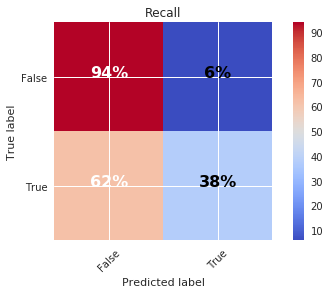

In [19]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["False", "True"],normalize=True,
                      title='Recall')

In [20]:
result_set = pd.DataFrame(actual)
result_set.rename(index=str,columns={0: "actual_outcome"},inplace=True)
result_set["predicted_outcome"] = result
#result_set[result_set.actual_outcome != result_set.predicted_outcome]

#### Show probability distribution of the results

In [21]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [22]:
softmax_probablity = np.round(softmax(prediction),2)

In [23]:
softmax_probablity

array([[0.94, 0.98, 0.91, ..., 0.62, 0.99, 0.99],
       [0.06, 0.02, 0.09, ..., 0.38, 0.01, 0.01]], dtype=float32)

In [24]:
result_set["false_proba"] = softmax_probablity[0]
result_set["true_proba"] = softmax_probablity[1]
result_set.head()

,actual_outcome,predicted_outcome,false_proba,true_proba
0,0,0,0.94,0.06
1,0,0,0.98,0.02
2,0,0,0.91,0.09
3,0,0,0.95,0.05
4,1,0,0.90,0.10


In [25]:
def calculate_result_type(row):
    if (row.actual_outcome == 1) & (row.actual_outcome == row.predicted_outcome):
        return "True_Positive"
    elif (row.actual_outcome == 0) & (row.actual_outcome != row.predicted_outcome):
        return "False_Positive"
    elif (row.actual_outcome == 0) & (row.actual_outcome == row.predicted_outcome):
        return "True_Negative"
    elif (row.actual_outcome == 1) & (row.actual_outcome != row.predicted_outcome):
        return "False_Negative"

In [26]:
result_set['Result_Type'] = result_set.apply(calculate_result_type, axis=1)
result_set.head(10)

,actual_outcome,predicted_outcome,false_proba,true_proba,Result_Type
0,0,0,0.94,0.06,True_Negative
1,0,0,0.98,0.02,True_Negative
2,0,0,0.91,0.09,True_Negative
3,0,0,0.95,0.05,True_Negative
4,1,0,0.90,0.10,False_Negative
5,0,0,0.83,0.17,True_Negative
6,0,0,0.98,0.02,True_Negative
7,1,1,0.15,0.85,True_Positive
8,0,0,0.99,0.01,True_Negative
9,0,0,0.96,0.04,True_Negative


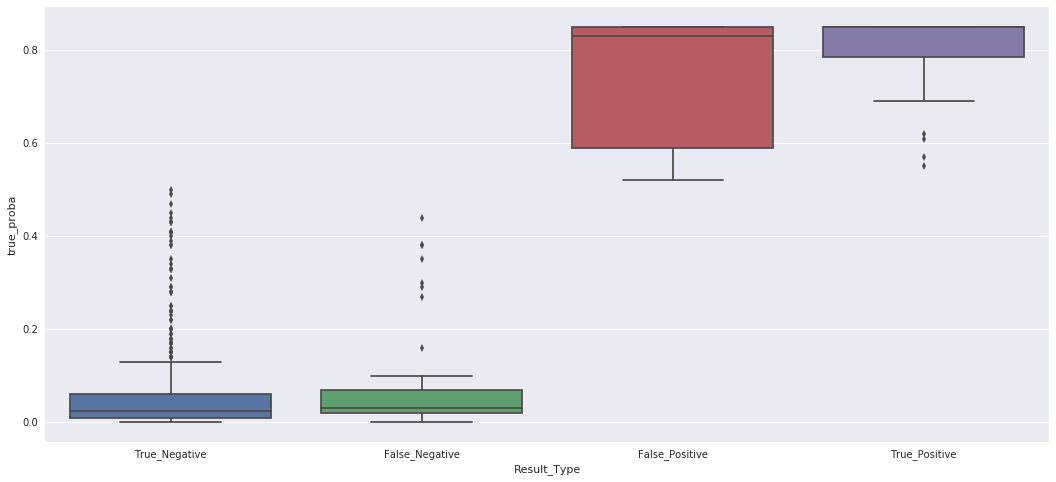

In [27]:
#result_set.sort_values(['true_proba'],inplace=True)
fig, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=(18,8))
sns.boxplot(y="true_proba",x="Result_Type", data=result_set.sort_values(by=["true_proba"]),ax=ax1)

In [28]:
pd.options.display.float_format = '{:.2f}'.format
result_set[result_set.Result_Type == "True_Negative"].true_proba.describe()

count   610.00
mean      0.05
std       0.09
min       0.00
25%       0.01
50%       0.02
75%       0.06
max       0.50
Name: true_proba, dtype: float64

In [29]:
pd.options.display.float_format = '{:.2f}'.format
result_set[result_set.Result_Type == "False_Negative"].true_proba.describe()

count   57.00
mean     0.07
std      0.11
min      0.00
25%      0.02
50%      0.03
75%      0.07
max      0.44
Name: true_proba, dtype: float64

In [30]:
pd.options.display.float_format = '{:.2f}'.format
result_set[result_set.Result_Type == "True_Positive"].true_proba.describe()

count   35.00
mean     0.80
std      0.09
min      0.55
25%      0.78
50%      0.85
75%      0.85
max      0.85
Name: true_proba, dtype: float64

In [31]:
pd.options.display.float_format = '{:.2f}'.format
result_set[result_set.Result_Type == "False_Positive"].true_proba.describe()

count   39.00
mean     0.74
std      0.13
min      0.52
25%      0.59
50%      0.83
75%      0.85
max      0.85
Name: true_proba, dtype: float64